In [5]:
import dalex as dx
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import lime.lime_tabular
import lime.lime_image
import warnings
import sys

sys.path.append('../')

from src import LDA, metrics
from sklearn.model_selection import train_test_split
plt.style.use('seaborn-paper')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('lines', markersize=10)

In [6]:
df = pd.read_csv('../dataset/breast-cancer-wisconsin-processed.csv')
label = pd.read_csv('../dataset/breast-cancer-wisconsin-processed-label.csv')
data = pd.concat([df, label], axis=1)

X = data.drop('diagnosis', axis=1)
y = data['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

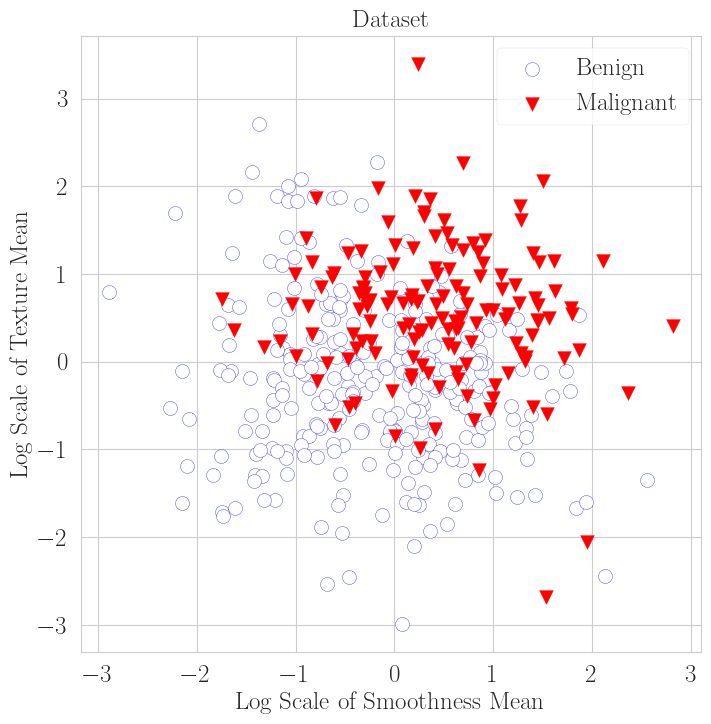

In [7]:
plt.subplots(figsize=(8, 8))
plt.title('Dataset')
plt.scatter(X_train[y_train == 0]['smoothness_mean_log'], X_train[y_train == 0]['texture_mean_log'], marker='o',
            label='Benign', s=100, edgecolors='blue', facecolors='white')
plt.scatter(X_train[y_train == 1]['smoothness_mean_log'], X_train[y_train == 1]['texture_mean_log'], marker='v',
            label='Malignant', s=100, edgecolors='red', facecolors='red')
plt.xlabel('Log Scale of Smoothness Mean')
plt.ylabel('Log Scale of Texture Mean')
plt.legend()
plt.show()

In [10]:
path_to_plot = '../src/output_plots/'
filetype = '.pdf'

model = LDA.LDA()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Confusion matrix:
[[71  0]
 [ 5 32]]


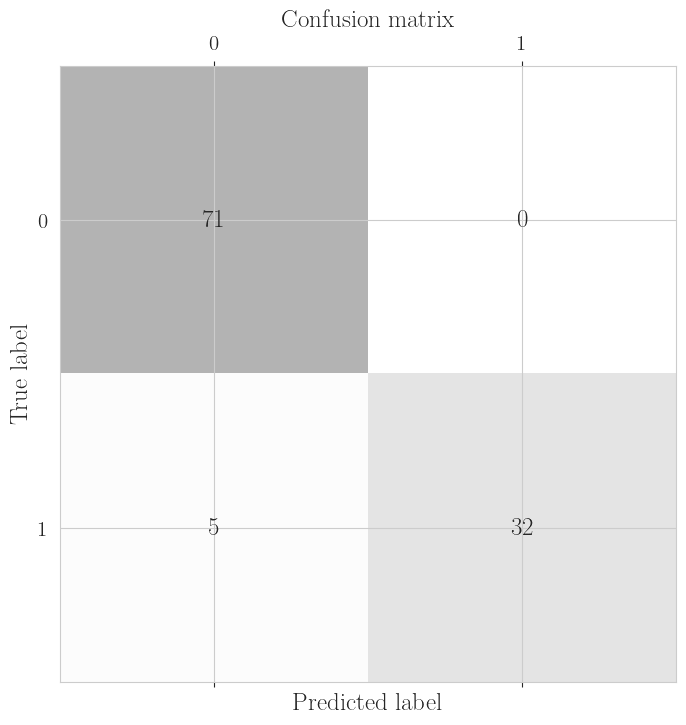

In [11]:
metrics.confusion_matrix(y_test, y_pred, save=True, save_to=path_to_plot + 'LDA_confusion_matrix' + filetype)

In [12]:
print("Accuracy: ", metrics.accuracy(y_test, y_pred))
print("Precision: ", metrics.precision(y_test, y_pred))
print("Recall: ", metrics.recall(y_test, y_pred))
print("F1: ", metrics.f1_score(y_test, y_pred))

Accuracy:  0.9537037037037037
Precision:  1.0
Recall:  0.8648648648648649
F1:  0.927536231884058


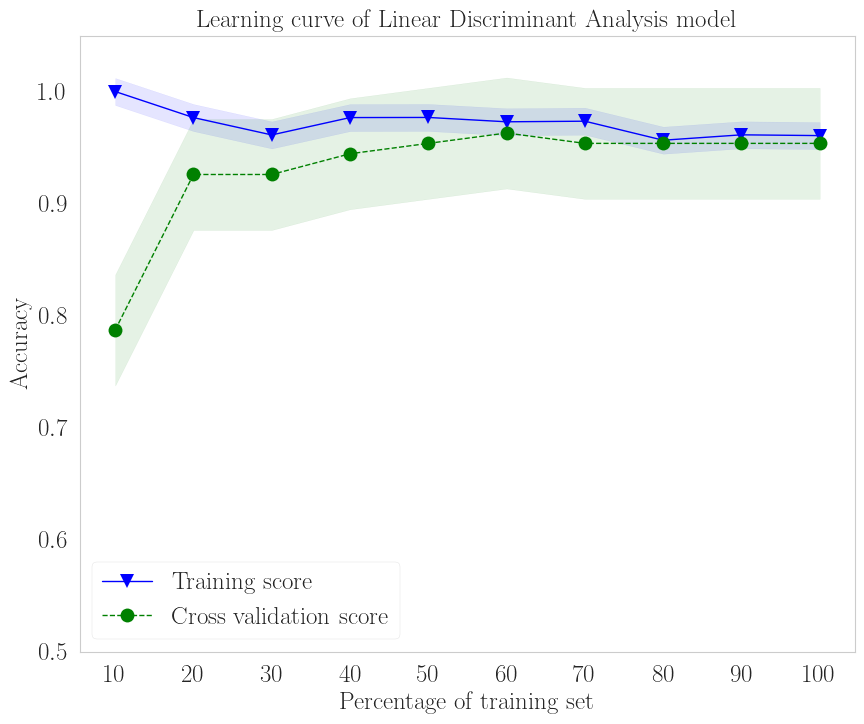

In [14]:
metrics.learning_curve_lda(X_train, y_train, X_test, y_test, save=True, save_to=path_to_plot + 'LDA_learning_curve' + filetype)

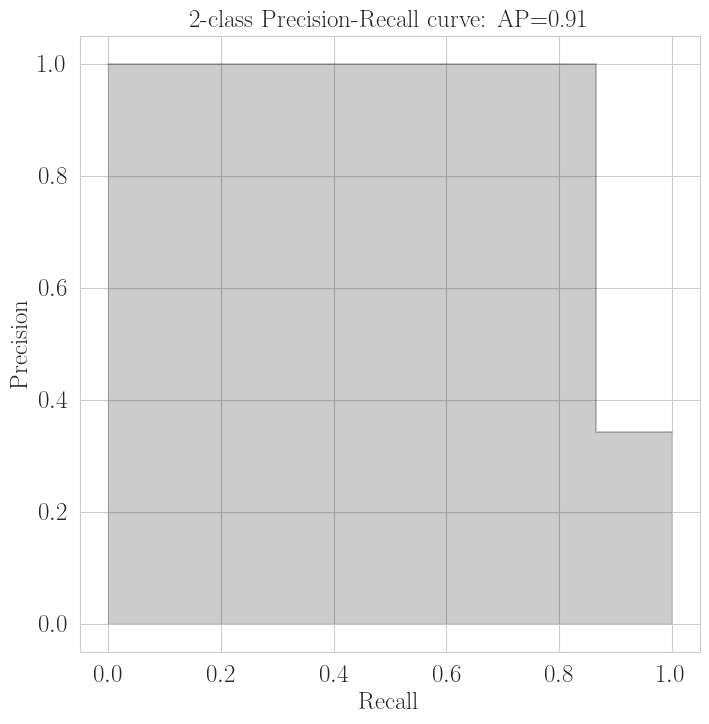

In [15]:
metrics.precision_recall_curve(y_test, y_pred, save=True, save_to=path_to_plot + 'LDA_precision_recall_curve' + filetype)

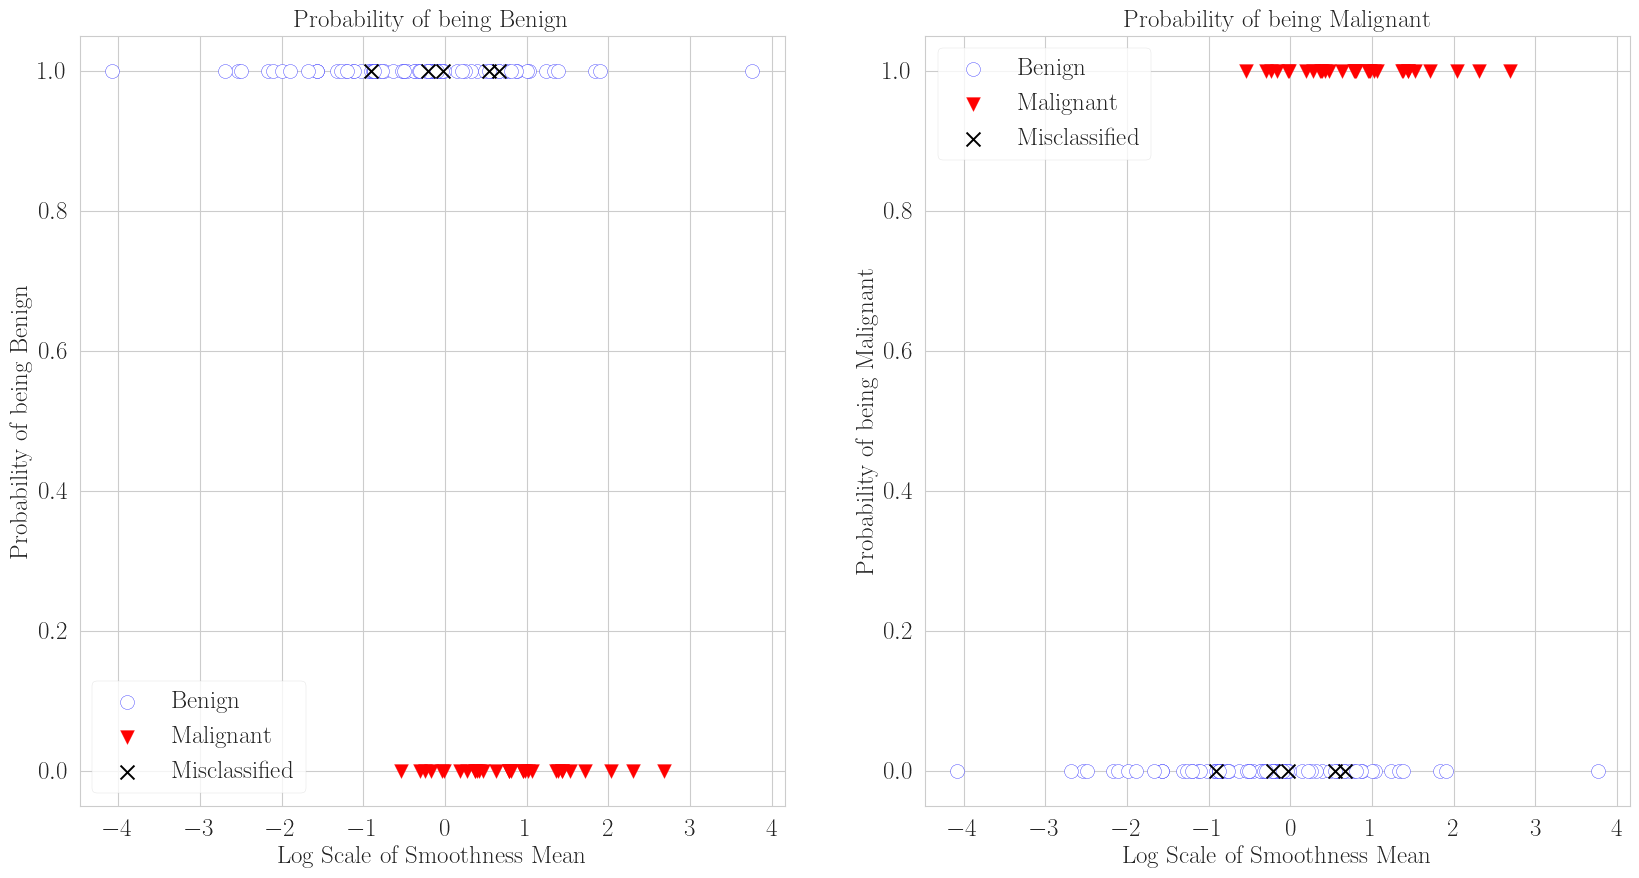

In [16]:
#Log scale of smoothness mean1
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].set_title('Probability of being Benign')
ax[0].scatter(X_test[y_pred == 0]['smoothness_mean_log'], model.predict_proba_to_plot(X_test[y_pred == 0])[:, 0], marker='o',
              label='Benign', s=100, edgecolors='blue', facecolors='white')
ax[0].scatter(X_test[y_pred == 1]['smoothness_mean_log'], model.predict_proba_to_plot(X_test[y_pred == 1])[:, 0], marker='v',
              label='Malignant', s=100, edgecolors='red', facecolors='red')
ax[0].scatter(X_test[y_pred != y_test]['smoothness_mean_log'], model.predict_proba_to_plot(X_test[y_pred != y_test])[:, 0],
              marker='x', label='Misclassified', s=100, edgecolors='black', facecolors='black')
ax[0].set_xlabel('Log Scale of Smoothness Mean')
ax[0].set_ylabel('Probability of being Benign')
ax[0].legend()
ax[1].set_title('Probability of being Malignant')

ax[1].scatter(X_test[y_pred == 0]['smoothness_mean_log'], model.predict_proba_to_plot(X_test[y_pred == 0])[:, 1], marker='o',
              label='Benign', s=100, edgecolors='blue', facecolors='white')
ax[1].scatter(X_test[y_pred == 1]['smoothness_mean_log'], model.predict_proba_to_plot(X_test[y_pred == 1])[:, 1], marker='v',
              label='Malignant', s=100, edgecolors='red', facecolors='red')
ax[1].scatter(X_test[y_pred != y_test]['smoothness_mean_log'], model.predict_proba_to_plot(X_test[y_pred != y_test])[:, 1],
              marker='x', label='Misclassified', s=100, edgecolors='black', facecolors='black')
ax[1].set_xlabel('Log Scale of Smoothness Mean')
ax[1].set_ylabel('Probability of being Malignant')
ax[1].legend()
plt.savefig(path_to_plot + 'LDA_probability' + filetype)
plt.show()

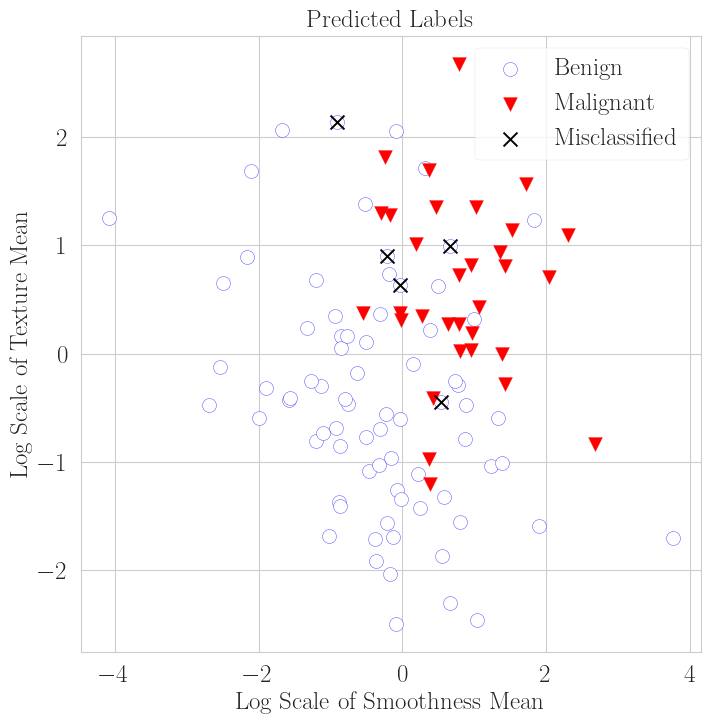

In [17]:
plt.subplots(figsize=(8, 8))
plt.title('Predicted Labels')
plt.scatter(X_test[y_pred == 0]['smoothness_mean_log'], X_test[y_pred == 0]['texture_mean_log'], marker='o',
            label='Benign', s=100, edgecolors='blue', facecolors='white')
plt.scatter(X_test[y_pred == 1]['smoothness_mean_log'], X_test[y_pred == 1]['texture_mean_log'], marker='v',
            label='Malignant', s=100, edgecolors='red', facecolors='red')
plt.scatter(X_test[y_pred != y_test]['smoothness_mean_log'], X_test[y_pred != y_test]['texture_mean_log'], marker='x',
            label='Misclassified', s=100, edgecolors='black', facecolors='black')
plt.xlabel('Log Scale of Smoothness Mean')
plt.ylabel('Log Scale of Texture Mean')
plt.legend()
plt.savefig(path_to_plot + 'LDA_predicted_labels' + filetype)
plt.show()

In [18]:
misclassified = X_test[y_pred != y_test]

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns,
                                                   class_names=['Benign', 'Malignant'],
                                                   discretize_continuous=True, verbose=True, mode='classification')
for i in misclassified.index:
    exp = explainer.explain_instance(X_test.loc[i].values, model.predict_proba_to_plot, num_features=10)
    exp.show_in_notebook(show_table=True, show_all=True)

Intercept 0.465131664481614
Prediction_local [0.42942816]
Right: 0.0


Intercept 0.42732363721533667
Prediction_local [0.51542331]
Right: 0.0


Intercept 0.46566355261858355
Prediction_local [0.40401556]
Right: 0.0


Intercept 0.4984909102611119
Prediction_local [0.3494649]
Right: 0.0


Intercept 0.4338599857224308
Prediction_local [0.47359432]
Right: 0.0


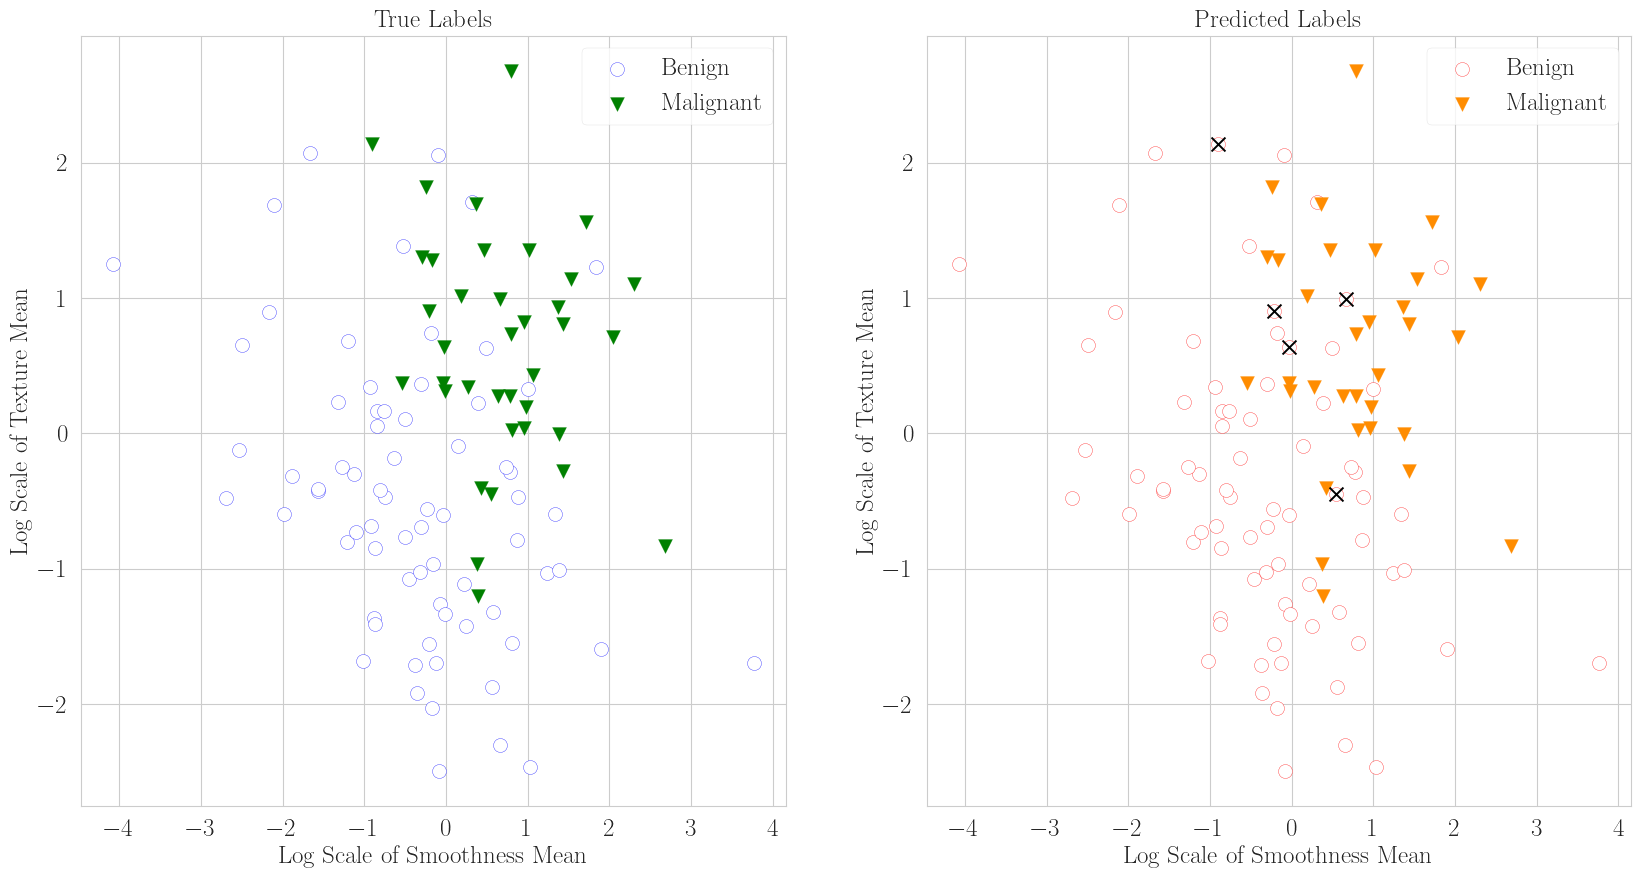

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].set_title('True Labels')
ax[0].scatter(X_test[y_test == 0]['smoothness_mean_log'], X_test[y_test == 0]['texture_mean_log'], marker='o',
              label='Benign', s=100, edgecolors='blue', facecolors='white')
ax[0].scatter(X_test[y_test == 1]['smoothness_mean_log'], X_test[y_test == 1]['texture_mean_log'], marker='v',
              label='Malignant', s=100, edgecolors='green', facecolors='green')
ax[0].set_xlabel('Log Scale of Smoothness Mean')
ax[0].set_ylabel('Log Scale of Texture Mean')
ax[0].legend()

ax[1].set_title('Predicted Labels')
ax[1].scatter(X_test[y_pred == 0]['smoothness_mean_log'], X_test[y_pred == 0]['texture_mean_log'], marker='o',
              label='Benign', s=100, edgecolors='red', facecolors='white')
ax[1].scatter(X_test[y_pred == 1]['smoothness_mean_log'], X_test[y_pred == 1]['texture_mean_log'], marker='v',
              label='Malignant', s=100, edgecolors='darkorange', facecolors='darkorange')
ax[1].set_xlabel('Log Scale of Smoothness Mean')
ax[1].set_ylabel('Log Scale of Texture Mean')
ax[1].legend()
for i in range(len(y_test)):
    if y_test.iloc[i] != y_pred[i]:
        ax[1].scatter(X_test.iloc[i]['smoothness_mean_log'], X_test.iloc[i]['texture_mean_log'], marker='x',
                      label='Incorrect', s=100, edgecolors='black', facecolors='black')
plt.savefig(path_to_plot + 'LDA_true_vs_predicted' + filetype)
plt.show()